# **라이브러리 불러오기**

In [1]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [3]:
import os
os.chdir('../신용카드연체예측')

In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [5]:
# path = '/content/drive/MyDrive/신용카드연체예측/'

In [6]:
# train=pd.read_csv(path + 'train.csv')
# test=pd.read_csv(path + 'test.csv')
# submission=pd.read_csv(path + 'sample_submission.csv')

# **[데이터 살펴보기]**

In [7]:
train.head(2)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


In [8]:
test.head(2)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0


In [9]:
train.shape

(26457, 20)

In [10]:
test.shape

(10000, 19)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

# **[데이터 전처리]**

**(주의) train data에 해준 그대로 test data 전처리**

## **1. 결측치 제거** 

In [12]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [13]:
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

In [14]:
train.drop(['index', 'FLAG_MOBIL',
            # 'work_phone'
            ], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL', 
        #    'work_phone'
           ], axis=1, inplace=True)


In [15]:
# train=train.drop('occyp_type', axis=1)
# test=test.drop('occyp_type', axis=1)
display(train['occyp_type'].unique())
display(test['occyp_type'].unique())

array(['NaN', 'Laborers', 'Managers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
       'Accountants', 'Realty agents', 'Security staff', 'Cleaning staff',
       'Private service staff', 'Cooking staff', 'Secretaries',
       'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

array(['NaN', 'Core staff', 'Laborers', 'Drivers', 'Managers',
       'Sales staff', 'Cleaning staff', 'Accountants', 'Cooking staff',
       'Medicine staff', 'Realty agents', 'Waiters/barmen staff',
       'Private service staff', 'High skill tech staff',
       'Low-skill Laborers', 'Security staff', 'Secretaries', 'HR staff',
       'IT staff'], dtype=object)

## **2. Binary variables**

In [16]:
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0    17697
1     8760
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16410
1    10047
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    18672
1     7785
Name: phone, dtype: int64
--------------
Having a email or not: 
0    24042
1     2415
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    20511
1     5946
Name: work_phone, dtype: int64
--------------


## **3. Continuous variable**

### (1) child_num

<AxesSubplot:>

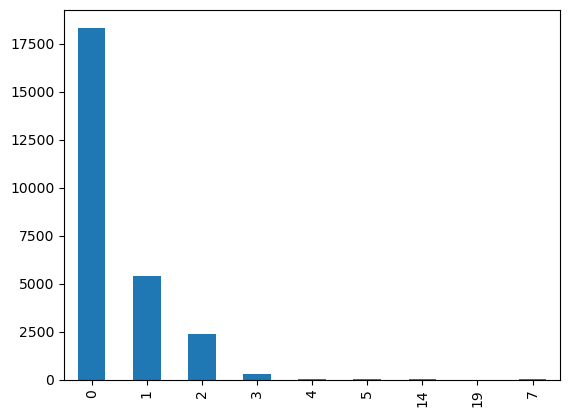

In [17]:
train['child_num'].value_counts(sort=False).plot.bar()

In [18]:
train.loc[train['child_num'] >= 3,'child_num']=3
test.loc[test['child_num'] >= 3, 'child_num']=3

In [19]:
# family_size
train['family_size'].value_counts().sort_values(ascending = False)
# .plot.bar()


2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [20]:
test['family_size'].value_counts().sort_values(ascending=False)


2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64

In [21]:
train.loc[train['family_size'] > 7, 'family_size'] = 7
test.loc[test['family_size'] > 7, 'family_size'] = 7

### (2) inc

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

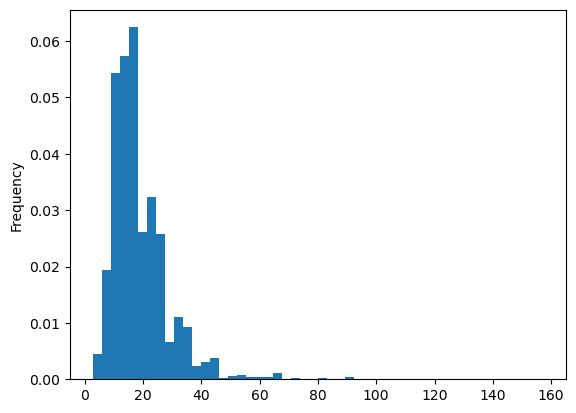

In [22]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000 
test['income_total'] = test['income_total']/10000
##############################################################3
print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [23]:

train['income_mean'] = train['income_total'] / train['family_size']
test['income_mean'] = test['income_total'] / test['family_size']
train['income_mean']


0        10.125
1          8.25
2          22.5
3        10.125
4         7.875
          ...  
26452     5.625
26453       9.0
26454    14.625
26455      17.1
26456      4.05
Name: income_mean, Length: 26457, dtype: object

In [24]:
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)


In [25]:
# train = train[(train['family_size'] <= 7)]
# train = train.reset_index(drop=True)

In [26]:
test

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,income_mean
0,1,1,0,0,소득0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,0,1,0,NaN,2.0,-60.0,5.6250
1,0,0,1,0,소득0,State servant,Higher education,Married,House / apartment,-18964,-8671,0,1,0,Core staff,2.0,-36.0,6.7500
2,0,0,1,0,소득0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,0,Laborers,2.0,-40.0,3.4686
3,1,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,0,0,Drivers,2.0,-41.0,5.6250
4,0,1,1,0,소득0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,0,0,Managers,2.0,-8.0,11.2500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,1,0,소득0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,0,Accountants,2.0,-19.0,10.1250
9996,1,1,1,0,소득0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,0,0,Laborers,2.0,-34.0,10.1250
9997,0,0,1,0,소득1,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,0,0,0,Medicine staff,2.0,-55.0,14.6250
9998,0,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,0,1,0,NaN,2.0,-33.0,9.0000


### **(3) Type**

In [27]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [28]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])
########################################################################
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])
########################################################################
train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])
########################################################################
train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])
########################################################################
train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])
########################################################################
train['occyp_type']=label_encoder.fit_transform(train['occyp_type'])
test['occyp_type']=label_encoder.fit_transform(test['occyp_type'])

## **4. Minus continuous variable**

In [29]:
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    ##########################################################
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [30]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'credit', 'income_mean'],
      dtype='object')

In [31]:
train[['DAYS_EMPLOYED']].describe()

,DAYS_EMPLOYED
count,26457.000000
mean,59068.750728
std,137475.427503
min,-15713.000000
25%,-3153.000000
50%,-1539.000000
75%,-407.000000
max,365243.000000


In [32]:
train['income_mean'].describe()

count     26457.00
unique      371.00
top           6.75
freq       2175.00
Name: income_mean, dtype: float64

In [33]:
# DAYS_BIRTH
# 출생일
# 최대 - 최소 = 17,447 (일) = 581 (개월) = 48.46 (년) -> 약 50 (년)

# DAYS_EMPLOYED
# 업무 시작일
# 최대 - 최소 = 380,956 (일) = 12698.53 (개월) = 1058 (년)
# 양수 값 처리 -> 고용되지 않은 상태임 -> 0
# 처리 후 -> 523 (개월) -> 약 43.64 (년)

# begin_month
# 신용카드 발급월
# 최대 - 최소 = 60 (개월) = 5 (년)

In [34]:
train.loc[train['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0

In [35]:
train['Age'] = train['DAYS_BIRTH'] // 365
test['Age'] = test['DAYS_BIRTH'] // 365

In [36]:
make_bin('DAYS_BIRTH', n=10)        
make_bin('DAYS_EMPLOYED', n=4)      
make_bin('begin_month', n=5)

In [37]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_mean,Age
0,0,0,0,0,0,0,1,1,2,3,1,0,0,0,12,2.0,0,1.0,10.125,-39
1,0,0,1,1,0,0,4,0,1,2,0,0,0,1,8,3.0,0,1.0,8.25,-32
2,1,1,1,0,1,4,1,1,1,6,1,0,1,0,10,2.0,1,2.0,22.5,-53
3,0,0,1,0,0,0,4,1,1,4,0,0,1,0,15,2.0,3,0.0,10.125,-42
4,0,1,1,0,0,2,1,1,1,4,0,0,0,0,10,2.0,2,2.0,7.875,-42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,0,2,4,1,1,2,0,0,0,0,3,4.0,0,1.0,5.625,-34
26453,0,0,1,1,0,4,1,2,1,4,0,0,0,0,12,2.0,3,2.0,9.0,-42
26454,0,1,0,0,1,4,4,0,5,1,0,0,0,0,3,2.0,2,2.0,14.625,-28
26455,1,0,1,0,0,4,2,3,1,1,0,0,0,0,8,1.0,4,2.0,17.1,-28


In [38]:
test

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,income_mean,Age
0,1,1,0,0,0,1,4,0,1,8,0,0,1,0,12,2.0,4,5.6250,-61
1,0,0,1,0,0,2,1,1,1,6,2,0,1,0,3,2.0,2,6.7500,-52
2,0,0,1,0,0,4,4,1,1,4,0,1,1,0,8,2.0,3,3.4686,-44
3,1,1,0,0,0,0,4,1,1,6,0,1,0,0,4,2.0,3,5.6250,-53
4,0,1,1,0,0,2,1,1,1,5,2,1,0,0,10,2.0,0,11.2500,-49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,1,0,0,4,2,1,1,6,1,1,1,0,0,2.0,1,10.1250,-51
9996,1,1,1,0,0,4,4,0,1,1,0,1,0,0,8,2.0,2,10.1250,-30
9997,0,0,1,0,1,4,4,1,1,7,3,0,0,0,11,2.0,4,14.6250,-58
9998,0,1,0,0,0,0,4,1,1,5,0,0,1,0,12,2.0,2,9.0000,-46


In [39]:
train['income_mean'] = train['income_mean'].astype('float')
test['income_mean'] = test['income_mean'].astype('float')


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  int64  
 1   car            26457 non-null  int64  
 2   reality        26457 non-null  int64  
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  int64  
 5   income_type    26457 non-null  int64  
 6   edu_type       26457 non-null  int64  
 7   family_type    26457 non-null  int64  
 8   house_type     26457 non-null  int64  
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  occyp_type     26457 non-null  int64  
 15  family_size    26457 non-null  float64
 16  begin_month    26457 non-null  int64  
 17  credit         26457 non-null  float64
 18  income

In [41]:
train.shape

(26457, 20)

In [42]:
test.shape

(10000, 19)

<AxesSubplot:>

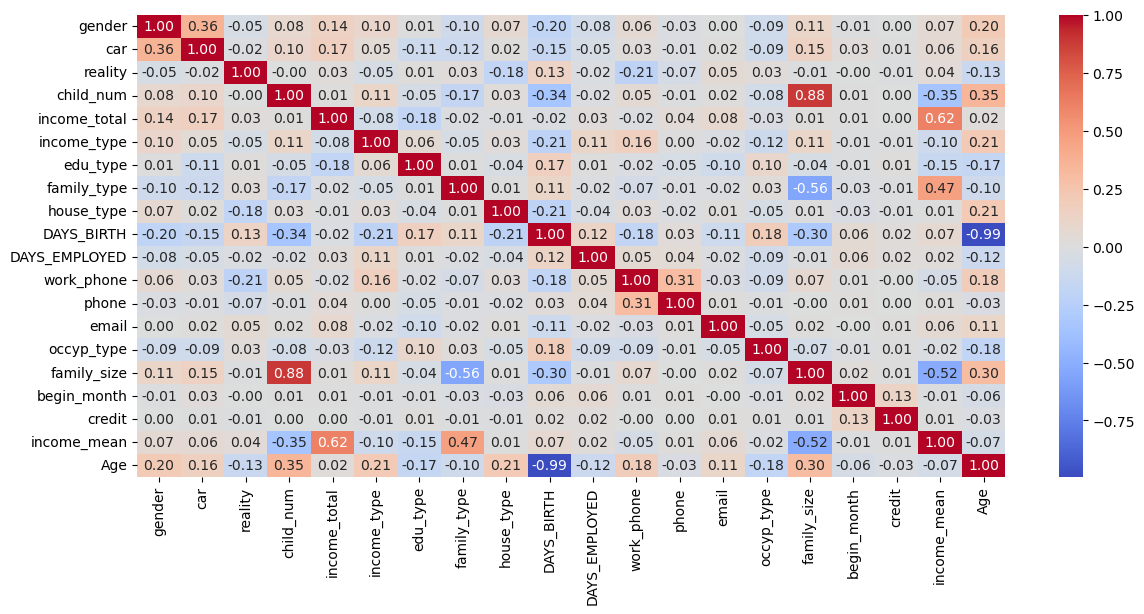

In [43]:
plt.figure(figsize = (14, 6))
sns.heatmap(train.corr(), fmt = '.2f',
            # vmin = -0.5, vmax = 0.5, 
            annot = True,
            cmap = 'coolwarm')

In [44]:
# cols = ['work_phone', 'family_size']
# train.drop(cols, axis=1, inplace=True)
# test.drop(cols, axis=1, inplace=True)


# **[데이터 모델링]**

In [45]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [46]:
%pip install category_encoders


Note: you may need to restart the kernel to use updated packages.


In [47]:
categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))
categorical_feats


Number of Categorical features:  0


[]

In [48]:
# from category_encoders.ordinal import OrdinalEncoder

# encoder = OrdinalEncoder(categorical_feats)
# train[categorical_feats] = encoder.fit_transform(
#     train[categorical_feats], train['credit'])
# test[categorical_feats] = encoder.transform(test[categorical_feats])


In [49]:
numeric_feats = train.drop(columns='credit').select_dtypes(include="number").columns.tolist()

In [50]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# train[numeric_feats] = scaler.fit_transform(train[numeric_feats])
# test[numeric_feats] = scaler.transform(test[numeric_feats])


In [51]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 19) (26457, 1) (10000, 19)


In [52]:
train_x

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,income_mean,Age
0,0,0,0,0,0,0,1,1,2,3,1,0,0,0,12,2.0,0,10.125,-39
1,0,0,1,1,0,0,4,0,1,2,0,0,0,1,8,3.0,0,8.250,-32
2,1,1,1,0,1,4,1,1,1,6,1,0,1,0,10,2.0,1,22.500,-53
3,0,0,1,0,0,0,4,1,1,4,0,0,1,0,15,2.0,3,10.125,-42
4,0,1,1,0,0,2,1,1,1,4,0,0,0,0,10,2.0,2,7.875,-42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,0,2,4,1,1,2,0,0,0,0,3,4.0,0,5.625,-34
26453,0,0,1,1,0,4,1,2,1,4,0,0,0,0,12,2.0,3,9.000,-42
26454,0,1,0,0,1,4,4,0,5,1,0,0,0,0,3,2.0,2,14.625,-28
26455,1,0,1,0,0,4,2,3,1,1,0,0,0,0,8,1.0,4,17.100,-28


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
# from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,
                                                  stratify=train_y, test_size=0.25,
                                                  random_state=10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)





Train set: 
(19842, 19)
(19842, 1)
Validation set: 
(6615, 19)
(6615, 1)


In [54]:
# clf = RandomForestClassifier()
clf = CatBoostClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_val)

# print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")
print(f"log_loss: {log_loss(y_val['credit'], y_pred)}")


Learning rate set to 0.092151
0:	learn: 1.0552243	total: 68.1ms	remaining: 1m 8s
1:	learn: 1.0208808	total: 72.6ms	remaining: 36.2s
2:	learn: 0.9930542	total: 77.6ms	remaining: 25.8s
3:	learn: 0.9703155	total: 80.4ms	remaining: 20s
4:	learn: 0.9517034	total: 84ms	remaining: 16.7s
5:	learn: 0.9363196	total: 98ms	remaining: 16.2s
6:	learn: 0.9234523	total: 104ms	remaining: 14.8s
7:	learn: 0.9127314	total: 109ms	remaining: 13.5s
8:	learn: 0.9037422	total: 114ms	remaining: 12.6s
9:	learn: 0.8964205	total: 122ms	remaining: 12.1s
10:	learn: 0.8897516	total: 131ms	remaining: 11.8s
11:	learn: 0.8842306	total: 137ms	remaining: 11.3s
12:	learn: 0.8795410	total: 142ms	remaining: 10.8s
13:	learn: 0.8761461	total: 147ms	remaining: 10.3s
14:	learn: 0.8723704	total: 152ms	remaining: 9.98s
15:	learn: 0.8696183	total: 161ms	remaining: 9.91s
16:	learn: 0.8673794	total: 171ms	remaining: 9.86s
17:	learn: 0.8654019	total: 177ms	remaining: 9.66s
18:	learn: 0.8634772	total: 182ms	remaining: 9.39s
19:	learn: 

In [55]:
log_loss_val = log_loss(y_val['credit'], y_pred)
log_loss_val = np.around(log_loss_val, 3)
log_loss(y_val['credit'], y_pred)


0.8091264167319345

In [56]:
def plot_feature_importance(importance, names, model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names,
            'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10, 8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')


In [57]:
clf.get_feature_importance(),test_x.columns

(array([ 3.19660898,  4.22640614,  3.66966078,  2.2858117 ,  1.76811107,
         5.67891748,  4.9212978 ,  5.04803703,  2.46635739,  2.68169165,
         2.48060609,  3.69703451,  4.08640765,  1.36975738, 11.22688514,
         2.6593862 ,  9.52271171, 15.56876642, 13.44554488]),
 Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
        'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
        'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
        'begin_month', 'income_mean', 'Age'],
       dtype='object'))

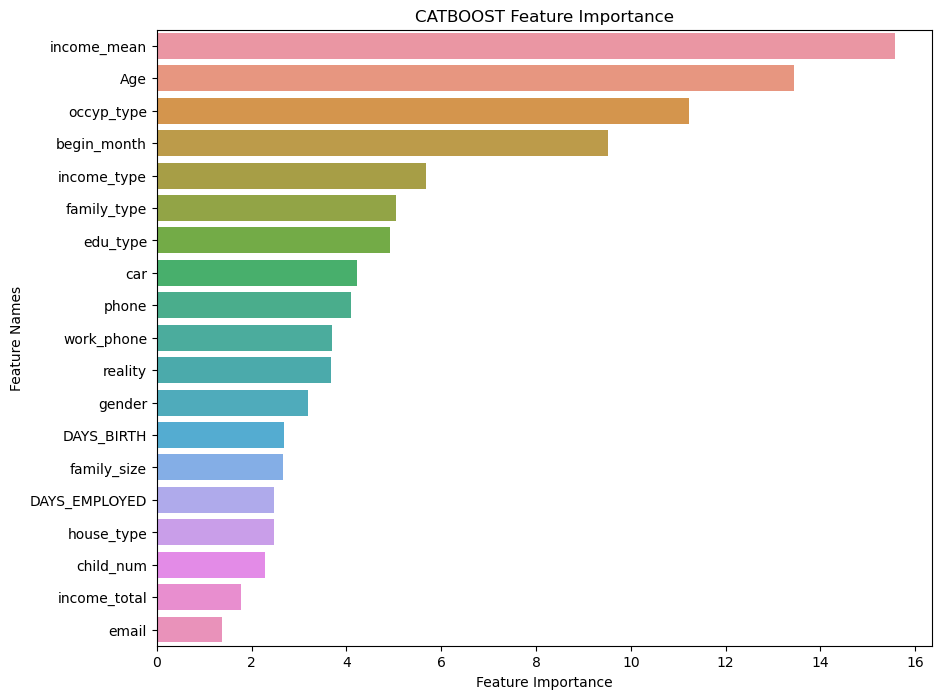

In [58]:
plot_feature_importance(clf.get_feature_importance(),test_x.columns,'CATBOOST')

In [59]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(y_val['credit'], predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

Learning rate set to 0.092455
0:	learn: 1.0548494	total: 8.06ms	remaining: 8.05s
1:	learn: 1.0202704	total: 13.8ms	remaining: 6.88s
2:	learn: 0.9923110	total: 19.5ms	remaining: 6.49s
3:	learn: 0.9694617	total: 25.2ms	remaining: 6.28s
4:	learn: 0.9507009	total: 29.9ms	remaining: 5.96s
5:	learn: 0.9352862	total: 47.5ms	remaining: 7.87s
6:	learn: 0.9229581	total: 51.6ms	remaining: 7.32s
7:	learn: 0.9121586	total: 56.2ms	remaining: 6.97s
8:	learn: 0.9030809	total: 61.2ms	remaining: 6.74s
9:	learn: 0.8960880	total: 68.6ms	remaining: 6.79s
10:	learn: 0.8895027	total: 73ms	remaining: 6.56s
11:	learn: 0.8837914	total: 86ms	remaining: 7.08s
12:	learn: 0.8789470	total: 91.1ms	remaining: 6.92s
13:	learn: 0.8755905	total: 97ms	remaining: 6.83s
14:	learn: 0.8720716	total: 104ms	remaining: 6.8s
15:	learn: 0.8693611	total: 111ms	remaining: 6.81s
16:	learn: 0.8671268	total: 116ms	remaining: 6.71s
17:	learn: 0.8650518	total: 120ms	remaining: 6.57s
18:	learn: 0.8634373	total: 125ms	remaining: 6.44s
19:	

In [60]:
my_submission

array([[0.09237386, 0.08250716, 0.82511898],
       [0.24333346, 0.09886264, 0.6578039 ],
       [0.13618699, 0.20751413, 0.65629888],
       ...,
       [0.04157351, 0.09001086, 0.86841563],
       [0.09380137, 0.20822995, 0.69796868],
       [0.05484889, 0.62728968, 0.31786143]])

In [61]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [62]:
submission.loc[:,1:]=my_submission

In [1484]:
submission

,index,0,1,2
0,26457,0.090420,0.065558,0.844022
1,26458,0.215820,0.082270,0.701911
2,26459,0.117699,0.181994,0.700308
3,26460,0.166530,0.175093,0.658377
4,26461,0.094679,0.316948,0.588373
...,...,...,...,...
9995,36452,0.093439,0.235658,0.670903
9996,36453,0.119542,0.203433,0.677026
9997,36454,0.043147,0.090173,0.866679
9998,36455,0.093922,0.203401,0.702677


In [1485]:
# sub_path = '/content/drive/MyDrive/신용카드연체예측/submission/'

In [1486]:
submission.to_csv(
    'submission/' + f'baseline_submission_{log_loss_val}.csv', index=False)


In [1487]:
# basline => 0.88
# Public / Private

########## RandomFroest ##########
# 1
# baseline_submission_0.983 -> 0.86583 / 0.8516
# 직업유형(occyp_type) label encoding

# 2
# baseline_submission_0.951 -> 0.86071 / 0.8465
# DAYS_EMPLOYED 양수 처리

# 3
# baseline_submission_0.923 -> 0.85454
# DAYS_BIRTH / DAYS_EMPLOYED / begin_month 통계자료 -> bins 개수 조정


############ XGBoost ############
# 4
# baseline_submission_0.856 -> 0.8738 / 0.8654
# XGBoost
# 오히려 성능이 더 떨어짐

########## CatBoost ##########
# 5
# baseline_submission_0.824  -> 0.8013 / 0.7931
# 결측치 제거
# 의미 없는 컬럼 제거 : index, FLAG_MOBIL
# FLAG_MOBIL : 전부 1로, 동일한 값을 가짐

# 6
# baseline_submission_0.819 -> 0.7978 / 0.7978
# Age 컬럼 추가

# 7
# baseline_submission_0.821 -> 
# family_size 7 이상 통일

# 8
# 
# DAYS_BIRTH, work_phone
# work_phone : credit과의 상관계수 0

# 9
# baseline_submission_0.808 -> 0.7904 / 0.7836
# work_phone먼 제외, DAYS_BIRTH 살리고
# income_mean 계산

